In [1]:
import os
import glob
import time
import pandas as pd
import numpy as np

# Text processing
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
#nltk.download("stopwords")

# Image processing
from skimage import io
from PIL import Image

# Deep learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set up CUDA
torch.cuda.empty_cache()

# Visualization
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import log_loss, accuracy_score

In [2]:
# CONSTANTS
DATA_ROOT = "./data/"
FLICKR_ROOT = "./flickr8k/"

## Part 1: Using LDA for topic modeling based on captions

### Data preparation

In [3]:
with open(FLICKR_ROOT+"text/Flickr8k.token.txt") as f:
    caption_data = f.read()

img_id_list, caption_list = [], []

# Create a list with all the image names
dataset_img_names = glob.glob(FLICKR_ROOT+"images/*.jpg")
dataset_img_names = [img_name.replace("\\", "/") for img_name in dataset_img_names]

# Iterate through each line of the captions file
for line in caption_data.split("\n"):
    if len(line) < 2:
        continue

    # Get the img id and the caption, separated by ","
    img_id, caption = line.split("\t", 1)

    # Remove the file extension from the img id
    img_id = img_id.split("#")[0]

    # Create the file path based on img id
    img_path = os.path.join(FLICKR_ROOT+"images/"+img_id)

    # Append the data to the two lists, if the id is actually in the provided images
    if img_path in dataset_img_names:
        img_id_list.append(img_path)
        caption_list.append(caption)

# Create a pandas dataframe with all the information
flickr_df = pd.DataFrame({"image": img_id_list, "caption": caption_list})

# Group all captions beloning to a single image (this way we get a longer caption which is probably bound to have repeated words)
flickr_df = flickr_df.groupby("image")["caption"].apply(lambda x: " ".join(x)).reset_index(name="caption")

In [4]:
# Tokenization, Stopword removal,Lemmatization and Stemming
def lemma_stem(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos="v"))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemma_stem(token))
    return result

# Preprocess all documents in df
flickr_df["caption"] = flickr_df["caption"].map(preprocess)

In [5]:
# Split into train, val and test as specified by the txt files
train_images = pd.read_csv(FLICKR_ROOT+"text/Flickr_8k.trainImages.txt", header=None)
train_images[0] = ["../../data/flickr8k/images/"+img_id for img_id in train_images[0]]

test_images = pd.read_csv(FLICKR_ROOT+"text/Flickr_8k.testImages.txt", header=None)
test_images[0] = ["../../data/flickr8k/images/"+img_id for img_id in test_images[0]]

val_images = pd.read_csv(FLICKR_ROOT+"text/Flickr_8k.devImages.txt", header=None)
val_images[0] = ["../../data/flickr8k/images/"+img_id for img_id in val_images[0]]

train_flickr_df = flickr_df.loc[flickr_df['image'].isin(train_images[0])]
test_flickr_df = flickr_df.loc[flickr_df['image'].isin(test_images[0])]
val_flickr_df = flickr_df.loc[flickr_df['image'].isin(val_images[0])]

print("Full:",flickr_df.shape, "Train:", train_flickr_df.shape, "Test:", test_flickr_df.shape, "Val:", val_flickr_df.shape)

Full: (8091, 2) Train: (6000, 2) Test: (1000, 2) Val: (1000, 2)


### LDA

In [6]:
# Create dictionary containing the word mappings
word_dict = gensim.corpora.Dictionary(train_flickr_df["caption"])
word_dict.filter_extremes(no_below=5)

# Build corpus from the dictionary of words (BoW)
bow_corpus = [word_dict.doc2bow(doc) for doc in train_flickr_df["caption"]]

In [7]:
# Build LDA model
n_topics = 15
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=word_dict, passes=2, workers=2)
# Compute perpexity (the lower the better)
print("LDA model perplexity:", lda_model.log_perplexity(bow_corpus), "\n\n")

# save the results
doc_lda = lda_model[bow_corpus]

# print out topics
for topic in lda_model.print_topics():
    print(topic)

LDA model perplexity: -5.822448028035694 


(0, '0.083*"woman" + 0.040*"sit" + 0.031*"stand" + 0.031*"wear" + 0.030*"rock" + 0.027*"shirt" + 0.020*"white" + 0.019*"girl" + 0.014*"jump" + 0.014*"hold"')
(1, '0.068*"girl" + 0.033*"littl" + 0.031*"child" + 0.031*"run" + 0.029*"young" + 0.020*"swing" + 0.020*"blue" + 0.019*"walk" + 0.019*"white" + 0.019*"hold"')
(2, '0.052*"skateboard" + 0.033*"mountain" + 0.028*"play" + 0.025*"snow" + 0.020*"children" + 0.019*"jump" + 0.018*"ramp" + 0.017*"snowi" + 0.016*"girl" + 0.016*"blue"')
(3, '0.033*"green" + 0.031*"water" + 0.030*"babi" + 0.029*"run" + 0.026*"woman" + 0.021*"tenni" + 0.020*"white" + 0.020*"grass" + 0.019*"push" + 0.016*"sit"')
(4, '0.053*"girl" + 0.047*"wear" + 0.031*"shirt" + 0.025*"young" + 0.024*"pool" + 0.020*"hold" + 0.017*"walk" + 0.017*"yellow" + 0.016*"woman" + 0.016*"drink"')
(5, '0.061*"jump" + 0.047*"white" + 0.041*"brown" + 0.036*"swim" + 0.033*"black" + 0.023*"pool" + 0.018*"young" + 0.016*"girl" + 0.013*"water" + 0.01

In [8]:
# Now we can actually discover the topic of a given document. So first let's define a function that will make the prediction and then apply it to the three dataframes

def predictTopics(corpus):
    caption_topics_df = pd.DataFrame()

    # Get main topic for each document
    for idx, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # This means it's a dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ",".join([word for word, prop in wp])
                caption_topics_df = caption_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    caption_topics_df.columns = ["Dominant_topic", "Perc_contribution", "Topic_keywords"]
    return caption_topics_df

# Use the above function on all three sets and check results
df = predictTopics([word_dict.doc2bow(doc) for doc in train_flickr_df["caption"]])
train_flickr_df = pd.concat([train_flickr_df.reset_index(drop=True), df], axis=1)

df = predictTopics([word_dict.doc2bow(doc) for doc in test_flickr_df["caption"]])
test_flickr_df = pd.concat([test_flickr_df.reset_index(drop=True), df], axis=1)

df = predictTopics([word_dict.doc2bow(doc) for doc in val_flickr_df["caption"]])
val_flickr_df = pd.concat([val_flickr_df.reset_index(drop=True), df], axis=1)

In [9]:
test_flickr_df

,image,caption,Dominant_topic,Perc_contribution,Topic_keywords
0,../../data/flickr8k/images/1056338697_4f7d7ce2...,"[blond, woman, blue, shirt, appear, wait, ride...",0.0,0.6720,"woman,sit,stand,wear,rock,shirt,white,girl,jum..."
1,../../data/flickr8k/images/106490881_5a2dd9b7b...,"[blue, swim, short, beach, smile, camera, beac...",7.0,0.6883,"peopl,black,beach,girl,jump,frisbe,white,sit,g..."
2,../../data/flickr8k/images/1082379191_ec1e53f9...,"[ladi, shirt, dock, woman, sit, dock, woman, s...",0.0,0.6497,"woman,sit,stand,wear,rock,shirt,white,girl,jum..."
3,../../data/flickr8k/images/1084040636_97d96335...,"[closeup, white, lay, head, paw, larg, white, ...",5.0,0.4819,"jump,white,brown,swim,black,pool,young,girl,wa..."
4,../../data/flickr8k/images/1096395242_fc69f0ae...,"[littl, orang, short, play, young, foot, outst...",1.0,0.5498,"girl,littl,child,run,young,swing,blue,walk,whi..."
...,...,...,...,...,...
995,../../data/flickr8k/images/929679367_ff8c7df2e...,"[beagl, play, tenni, ball, puppi, play, tenni,...",10.0,0.6458,"ball,dog,play,black,white,brown,mouth,run,socc..."
996,../../data/flickr8k/images/96420612_feb18fc6c6...,"[swim, trunk, jump, bodyboard, trunk, fli, boo...",5.0,0.3758,"jump,white,brown,swim,black,pool,young,girl,wa..."
997,../../data/flickr8k/images/968081289_cdba83ce2...,"[jump, dock, friend, watch, boy, climb, wooden...",8.0,0.5017,"water,jump,peopl,stand,bike,black,white,person..."
998,../../data/flickr8k/images/979383193_0a542a059...,"[group, children, wooden, tabl, group, young, ...",7.0,0.7938,"peopl,black,beach,girl,jump,frisbe,white,sit,g..."


## Part 2: Using CV to predict a topic and getting keywords for new images

### Create an instance of PyTorch's DataLoaded in order to load the Flickr dataset into the model

In [10]:
class FlickrImages(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe # make use of the dataframe for all the information loading
        self.transform = transform

    def __len__(self): return len(self.dataframe)

    def __getitem__(self, idx):
        if  torch.is_tensor(idx):
            idx.tolist()

        #image = io.imread(self.dataframe.iloc[idx, 0])
        image = Image.open(self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [11]:
# Load the data we generated before using the new custom dataset, splitting the datasets into train, test and val
# Before we can give the images as input to our CNN model we need to normalize them and then also tensorize them,
# Since the network expects as input a tensor of shape 3 x H x W
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize = transforms.Resize((224, 224))
to_tensor = transforms.ToTensor()

train_dataset = FlickrImages(train_flickr_df, transform=transforms.Compose([resize, to_tensor, normalize]))
test_dataset = FlickrImages(test_flickr_df, transform=transforms.Compose([resize, to_tensor, normalize]))
val_dataset = FlickrImages(val_flickr_df, transform=transforms.Compose([resize, to_tensor, normalize]))

# Use the DataLoader class to create iterables with batches over the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 3, 224, 224]) torch.Size([32])


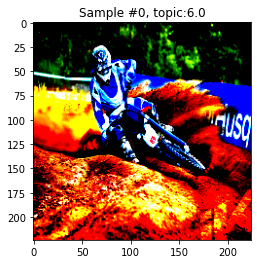

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


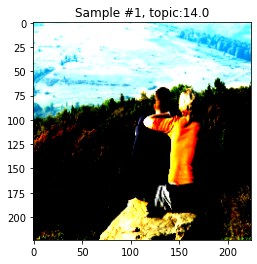

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


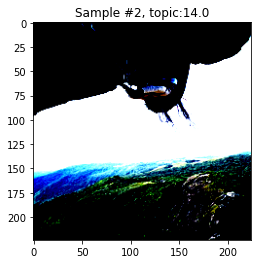

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


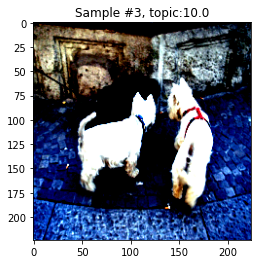

In [12]:
# Display the first 3 images and their corresponding labels from the batch
for batch_i, (imgs, labels) in enumerate(train_loader):
    print(batch_i, imgs.shape, labels.shape)

    for idx, img in enumerate(imgs):
        curr_lbl = labels[idx]
        plt.tight_layout()
        plt.title('Sample #{}, topic:{}'.format(idx, curr_lbl))
        plt.imshow(img.permute(1,2,0))
        plt.show()

        if idx == 3:
            break
    break

### VGGNet for image topic classification

In [13]:
# Load pre-trained VGGNet on ImageNet
vgg_model = torchvision.models.vgg19(pretrained=True)
vgg_model.to(device)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
# Of course the model is not usable right now, we must adapt it to our data
vgg_model.classifier[6].out_features = n_topics
for param in vgg_model.features.parameters():
    param.requires_grad = False # Here we are freezing the weights, meaning we're just using the information learned from ImageNet

In [15]:
# write method for training and validation
def train_model(model, dataloader, phase="train"):
    if phase == "train":
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_correct = 0

    for data in dataloader:
        x = data[0].to(device)
        y = data[1].long().to(device)

        if phase == "train":
            optimizer.zero_grad()

        output = model(x)
        loss = loss_fn(output, y)
        running_loss += loss.item()
        _, preds = torch.max(output, 1)
        running_correct += (preds==y).sum().item()

        if phase == "train":
            loss.backward()
            optimizer.step()

    loss = running_loss/len(dataloader.dataset)
    acc = 100. * running_correct/len(dataloader.dataset)
    print(phase, "loss:", loss, phase, "accuracy:", acc)

    return loss, acc

Epoch # 1
train loss: 0.0858283851146698 train accuracy: 24.05
val loss: 0.06366642737388611 val accuracy: 39.6
Epoch # 2
train loss: 0.07240466169516245 train accuracy: 32.9
val loss: 0.06522903835773468 val accuracy: 32.4
Epoch # 3
train loss: 0.06579071726401647 train accuracy: 40.71666666666667
val loss: 0.06568520319461822 val accuracy: 35.2
Epoch # 4
train loss: 0.0605939167936643 train accuracy: 46.31666666666667
val loss: 0.06553150725364686 val accuracy: 38.9
Epoch # 5
train loss: 0.05626896250247955 train accuracy: 51.083333333333336
val loss: 0.06743451595306396 val accuracy: 38.9
Epoch # 6
train loss: 0.048988210757573446 train accuracy: 58.43333333333333
val loss: 0.06798421001434327 val accuracy: 34.2
Epoch # 7
train loss: 0.0453247545560201 train accuracy: 61.96666666666667
val loss: 0.07232240426540375 val accuracy: 37.2
Epoch # 8
train loss: 0.04726077432433764 train accuracy: 63.95
val loss: 0.0713547134399414 val accuracy: 38.8
Epoch # 9
train loss: 0.043805086443821

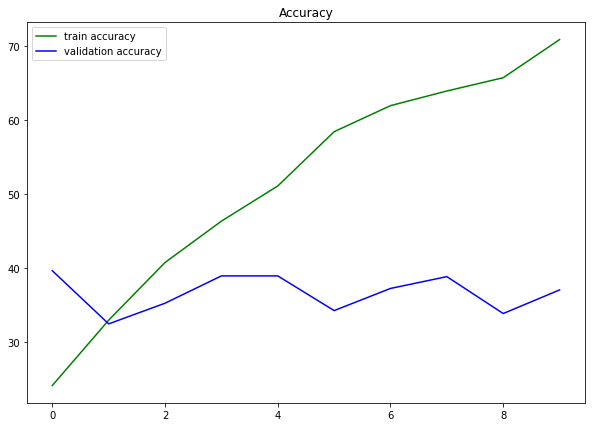

In [16]:
optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 10

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(n_epochs):
    print("Epoch #", epoch+1)
    train_epoch_loss, train_epoch_acc = train_model(vgg_model, train_loader)
    val_epoch_loss, val_epoch_acc = train_model(vgg_model, val_loader, phase="val")
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_acc)
end = time.time()

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [17]:
predicted_labels = []
for idx, (img, label) in enumerate(test_loader):
    test_in = img.to(device)
    model_out = vgg_model(test_in)
    _, pred = torch.max(model_out, 1)
    pred = float(pred.detach().cpu().numpy()[0])
    predicted_labels.append(pred)

accuracy = accuracy_score(test_flickr_df["Dominant_topic"].values, predicted_labels)
print("Accuracy on test set:", 100*accuracy)

Accuracy on test set: 39.1


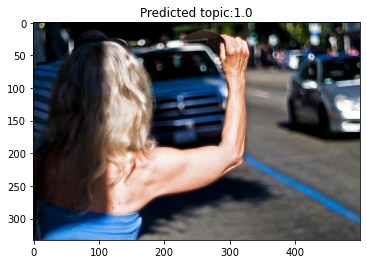

girl
littl
child
run
young
swing
blue
walk
white
hold


In [18]:
# Display the results on a single image
for idx, row in test_flickr_df.iterrows():
    img = io.imread(row["image"])
    curr_lbl = predicted_labels[idx]
    plt.tight_layout()
    plt.title('Predicted topic:{}'.format(curr_lbl))
    plt.imshow(img)
    plt.show()
    for word, weight in lda_model.get_topic_terms(int(curr_lbl)):
        print(word_dict[word])
    break